In [6]:
 %load_ext autoreload

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from tensorflow.keras.applications import EfficientNetB0
# from tqdm.auto import tqdm
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt


In [8]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.sampler import MultiShotMemorySampler
from tensorflow_similarity.sampler import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs

In [9]:
print('tf', tf.__version__)
print('tfsim', tfsim.__version__)
tf_cap_memory()

tf 2.4.0-rc3
tfsim 0.4.1alpha


# Preparing data
To demonstrate the ability of single-shot learning, we are going to train 
**fixme**


an index that contains a few examples of both even and odd digits to show how the model is able to do matching on 
unseen classes with few examples.


Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [10]:
NUM_TRAINING_CLASSES = 80  # max is 100 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# x_train = tf.constant(x_train / 255.0, dtype='float32')
# x_test = tf.constant(x_test / 255.0, dtype='float32')

# we need to reshape the Y to have a 1d array
y_train = tf.squeeze(y_train)
y_test = tf.squeeze(y_test)
print(x_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000,)


In [11]:
# select examples only for the first n classes
training_classes = list(range(NUM_TRAINING_CLASSES))
x_restricted, y_restricted = select_examples(x_train, y_train, training_classes, 600)
print(x_restricted.shape, y_restricted.shape)

(40000, 32, 32, 3) (40000,)


In [26]:
BATCH_SIZE = 16 #@param{Integer}
CLASS_PER_BATCH = 8
BATCH_PER_EPOCHS = 10000
sampler = MultiShotMemorySampler(x_restricted, y_restricted, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE, batch_per_epoch=BATCH_PER_EPOCHS)

In [27]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

In [28]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    return x

def get_model(input_shape=(32, 32, 3)):
    tf.keras.backend.clear_session()
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = EfficientNetB0(input_shape=input_shape, include_top=False)(x)

    # x = conv_block(x, 16)  
    # x = conv_block(x, 32)
    # x = conv_block(x, 64)
    # x = conv_block(x, 128)
    # x = conv_block(x, 256)
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = MetricEmbedding(16)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)         

In [29]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

In [30]:
STEPS_PER_EXECUTION = 10  # speedup execution by grouping batchs
model = get_model()
optimizer = Adam(0.002)
model.compile(optimizer=optimizer, steps_per_execution=STEPS_PER_EXECUTION, loss=triplet_loss)

In [31]:
EPOCHS = 10 #@param{Integer}
history = model.fit(sampler, validation_data=(x_test, y_test), epochs=EPOCHS)

Epoch 1/10
10000/10000 [==============================] - 741s 74ms/step - loss: 0.8780 - val_loss: 0.9765
Epoch 2/10
10000/10000 [==============================] - 672s 67ms/step - loss: 0.8667 - val_loss: 0.9745
Epoch 3/10
10000/10000 [==============================] - 614s 61ms/step - loss: 0.8592 - val_loss: 0.9723
Epoch 4/10
10000/10000 [==============================] - 736s 74ms/step - loss: 0.8450 - val_loss: 0.9678
Epoch 5/10
10000/10000 [==============================] - 765s 76ms/step - loss: 0.8429 - val_loss: 0.9689
Epoch 6/10
10000/10000 [==============================] - 761s 76ms/step - loss: 0.8389 - val_loss: 0.9604
Epoch 7/10
 2270/10000 [=====>........................] - ETA: 8:07 - loss: 0.8297

KeyboardInterrupt: 

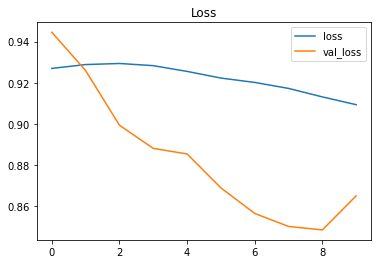

In [22]:
# let's visualizing loss overtime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

In [32]:
NUM_EXAMPLE_PER_CLASS = 50
x_index, y_index = select_examples(x_train, y_train, list(range(100)), NUM_EXAMPLE_PER_CLASS)

In [33]:
model.index_reset()
model.index(x_index, y_index)

Expected label: 36
  label    distances
-------  -----------
     90            0
     36            0
     48            0
     22            0
     64            0 



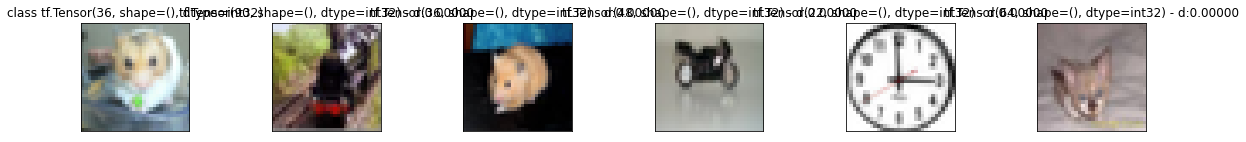

In [34]:
# query the closest points in our index for ALL 10000 test examples
num_neighboors = 5
test_id = 160  # 78 is a 9 a class we never trained on

# query closest matches
neighboors = model.single_lookup(x_test[test_id], k=num_neighboors)

# display results in tabular format
rows = [[n['label'], n['distance']] for n in neighboors]
print('Expected label: %d' % y_test[test_id])
print(tabulate(rows, headers=['label', 'distances']), '\n')

# view results close by
viz_neigbors_imgs(x_test[test_id], y_test[test_id], neighboors, fig_size=(20, 2))

In [38]:
model.index_summary()

[Index statistics]
----------------  ----
query_time           0
query                0
num_lookups        401
num_items         5000
stat_buffer_size   100
----------------  ----

[Query performance]
------  -----------
min     0
max     0.000499964
avg     2.49791e-05
median  0
stddev  0.000108881
------  -----------


In [39]:
num_calibration_samples = 200
calibration = model.calibrate(x_train
[:num_calibration_samples], y_train[:num_calibration_samples], k=3)

num positive matches 29/600



ZeroDivisionError: float division by zero

In [36]:
plt.plot(calibration['thresholds']['precision'], calibration['thresholds']['recall'])
plt.title("PR Curve")
plt.show()

NameError: name 'calibration' is not defined

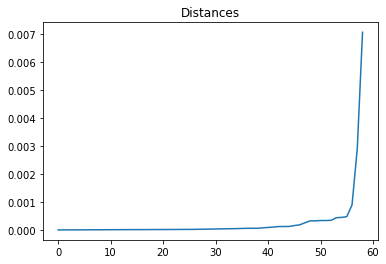

In [235]:
plt.plot(calibration['thresholds']['distance'])
plt.title("Distances")
plt.show()

In [236]:
rows = []
thresholds = calibration['thresholds']
for idx in range(len(thresholds['distance'])):
    rows.append([thresholds['distance'][idx], thresholds['f1'][idx], thresholds['precision'][idx], thresholds['recall'][idx]])

print(tabulate(rows, headers=['distance', 'f1', 'precision', 'recall']))

   distance        f1    precision    recall
-----------  --------  -----------  --------
3.8743e-06   0.78835          1         0.65
4.76837e-06  0.787645         0.99      0.66
5.00679e-06  0.784615         0.98      0.66
6.19888e-06  0.781609         0.97      0.66
6.31809e-06  0.778626         0.96      0.66
6.79493e-06  0.775665         0.95      0.66
7.86781e-06  0.782772         0.94      0.67
9.0003e-06   0.782931         0.93      0.68
9.53674e-06  0.782288         0.92      0.68
1.10269e-05  0.78245          0.91      0.69
1.11461e-05  0.780399         0.9       0.69
1.19805e-05  0.780576         0.89      0.7
1.30534e-05  0.78508          0.88      0.71
1.32322e-05  0.780919         0.87      0.71
1.46031e-05  0.783972         0.86      0.72
1.4782e-05   0.786207         0.85      0.73
1.50204e-05  0.780822         0.84      0.73
1.55568e-05  0.776831         0.83      0.73
1.70469e-05  0.782609         0.82      0.75
1.7643e-05   0.780731         0.81      0.76
1.80006e-05